In [20]:
import matplotlib.pyplot as plt
import numpy as np
import h5py
from HelperAndMechanics import *
from matplotlib import cm
from ipywidgets import *
import seaborn as sns
import pandas as pd

# Set Palatino as the default font
font = {'family': 'serif', 'serif': ['Palatino'], 'size': 20}
plt.rc('font', **font)
plt.rc('text', usetex=True)

In [21]:
import h5py
import numpy as np

def list_groups(file_path):
    """Returns a list of the first-layer group names in an HDF5 file (direct children of root)."""
    with h5py.File(file_path, 'r') as f:
        return [name for name in f if isinstance(f[name], h5py.Group)]

def load_run(file_path, run):
    """Reads the data and parameters from a saved HDF5 file."""
    data = {}
    params_dict = {}
    
    with h5py.File(file_path, 'r') as f:
        if run not in f:
            raise ValueError(f"Run '{run}' not found in file.")
        
        group = f[run]
        
        # Load datasets (if available)
        dataset_keys = ['u_sol', 'u', 'v_sol', 'v', 'T_sol', 'T', 'x_sol', 'x',
                        'u_BOCF', 'v_BOCF', 'T_BOCF', 'x_BOCF']
        
        for key in dataset_keys:
            if key in group:
                data[key] = np.array(group[key])
        
        # Load attributes from 'params_train' subgroup
        if "params_train" in group:
            params_group = group["params_train"]
            params_dict = {key: params_group.attrs[key] for key in params_group.attrs}
    
    return data, params_dict

def load_stat_data(file_path, mode):
    """
    Load the data from the HDF5 file and return the datasets and parameters.
    
    Parameters:
        file_path (str): Path to the HDF5 file.
        mode (str): Mode of operation ('AP_AP' or 'BOCF').
    
    Returns:
        u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params
    """
    run_list = list_groups(file_path)
    print("Available runs:", len(run_list))

    # Initialize storage lists
    u_sol, u_sim = [], []
    v_sol, v_sim = [], []
    T_sol, T_sim = [], []
    x_sol, x_sim = [], []
    params = {}

    for run in run_list:
        data, params_train = load_run(file_path, run)

        if not params:  # Initialize parameter dictionary once
            params = {key: [] for key in params_train.keys()}

        if mode == 'AP_AP':
            u_sol.append(data.get('u_sol', np.array([])))
            u_sim.append(data.get('u', np.array([])))
            v_sol.append(data.get('v_sol', np.array([])))
            v_sim.append(data.get('v', np.array([])))
            T_sol.append(data.get('T_sol', np.array([])))
            T_sim.append(data.get('T', np.array([])))
            x_sol.append(data.get('x_sol', np.array([])))
            x_sim.append(data.get('x', np.array([])))

        elif mode == 'BOCF':
            u_sol.append(data.get('u_sol', np.array([])))
            u_sim.append(data.get('u_BOCF', np.array([])))
            v_sol.append(data.get('v_sol', np.array([])))
            v_sim.append(data.get('v_BOCF', np.array([])))
            T_sol.append(data.get('T_sol', np.array([])))
            T_sim.append(data.get('T_BOCF', np.array([])))
            x_sol.append(data.get('x_sol', np.array([])))
            x_sim.append(data.get('x_BOCF', np.array([])))

        # Append parameters
        for key in params_train.keys():
            params[key].append(params_train[key])

    # Convert lists to NumPy arrays
    return (
        np.concatenate(u_sol) if u_sol else np.array([]),
        np.concatenate(u_sim) if u_sim else np.array([]),
        np.concatenate(v_sol) if v_sol else np.array([]),
        np.concatenate(v_sim) if v_sim else np.array([]),
        np.concatenate(T_sol) if T_sol else np.array([]),
        np.concatenate(T_sim) if T_sim else np.array([]),
        np.concatenate(x_sol) if x_sol else np.array([]),
        np.concatenate(x_sim) if x_sim else np.array([]),
        {key: np.array(val) for key, val in params.items()}
    )

def violin_plot(file_path, mode, selected_keys,params_true):
    """
    Generates a violin plot for selected parameters normalized by their true values.

    Parameters:
        file_path (str): Path to the HDF5 file.
        mode (str): Mode of operation ('AP_AP' or 'BOCF').
        selected_keys (list): List of parameter names to include in the plot.
    """
    # Load data
    _, _, _, _, _, _, _, _, params = load_stat_data(file_path, mode)


    # Normalize selected parameters
    normalized_params = {}
    for key in selected_keys:
        if key in params and key in params_true:
            normalized_params[key] = params[key] / params_true[key]
    
    # Convert to DataFrame
    df = pd.DataFrame(normalized_params)

    # Create the violin plot
    plt.figure(figsize=(12, 6))
    sns.violinplot(data=df, inner="quartile", palette="coolwarm")
    sns.stripplot(data=df, color='black', jitter=True, alpha=0.5, zorder=3)  # Individual data points

    # Add grid in the background
    plt.grid(True, linestyle="--", alpha=0.6, zorder=0)
    # Add horizontal line at y=1
    # plt.axhline(y=1, linestyle="-",color='black', linewidth=1, zorder=1, label="True Value")
    # Labels and title
    plt.xticks(rotation=45)
    plt.title(f"Normalized Parameters")
    # plt.legend(bbox_to_anchor=(1.0, 1.03), loc='upper left')

    # Show the plot
    plt.show()


In [22]:
file_path = '../data/SpringMassModel/FullDomain/FitAllParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarTrue.h5'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params = load_stat_data(file_path, mode)

Available runs: 20


In [23]:
keys =['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing']
N,size,params_true = read_config(['k_T','k_ij','k_ij_pad','k_j','k_a','k_a_pad','c_a','m','c_damp','n_0','l_0','spacing','D','a','k','mu_1','mu_2','epsilon_0','spacing'],mode = 'chaos')
params_true = dict(zip(keys,params_true))

mech_keys = ['c_damp','k_ij','k_a','k_j','l_0','c_a','k_T','n_0']
electric_keys = ['D','a','k','mu_1','mu_2','epsilon_0','spacing']
gaussian_keys = [f'Amp{i}{j}' for i in range(3) for j in range(3)]
for key in gaussian_keys:
    params_true[key] = 1

Available runs: 20


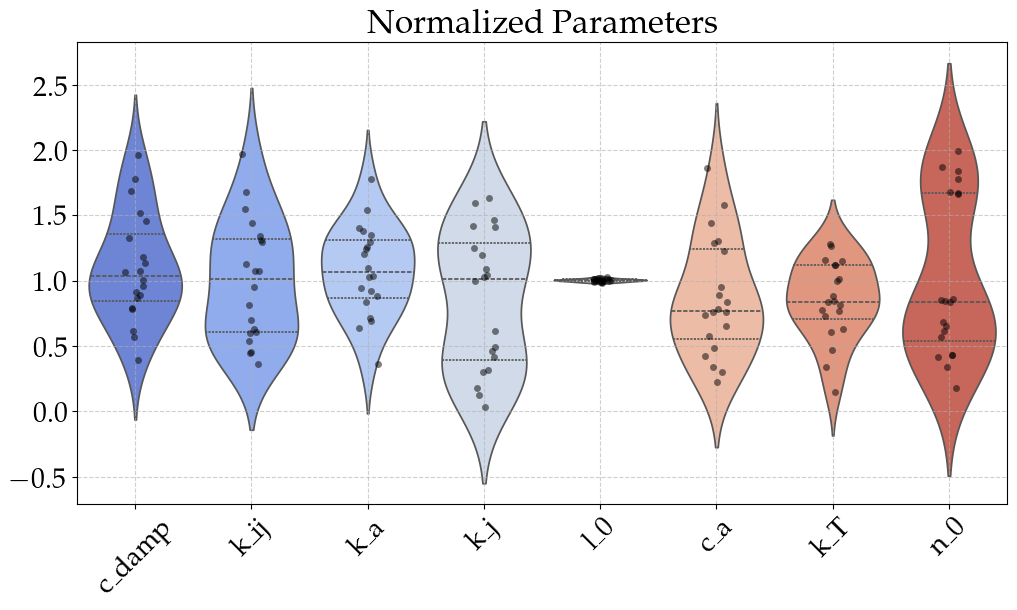

In [24]:
violin_plot(file_path, mode="AP_AP", selected_keys=mech_keys,params_true=params_true)

Available runs: 20


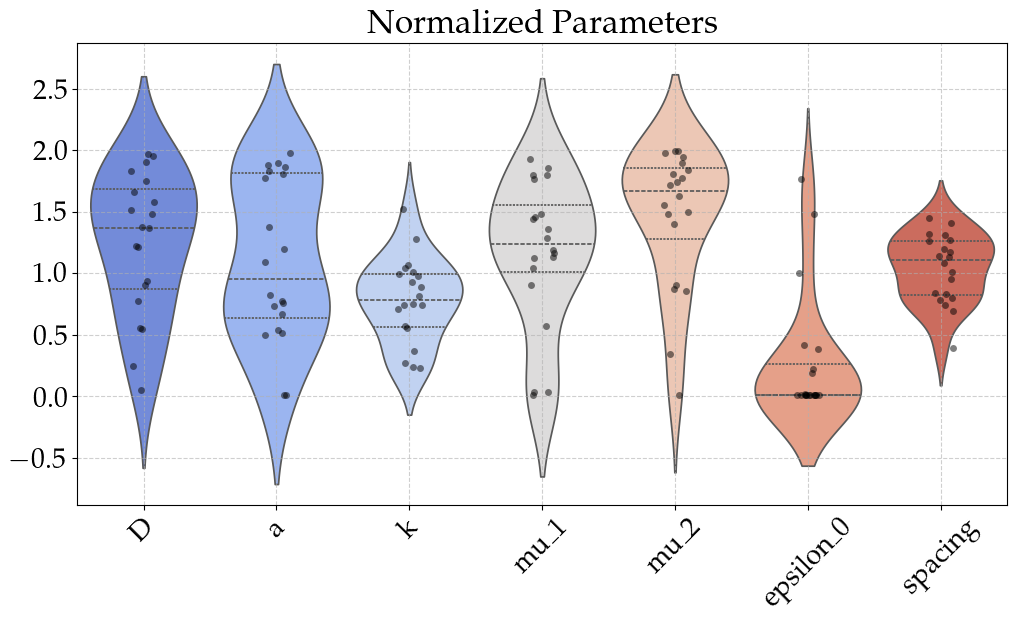

In [25]:
violin_plot(file_path, mode="AP_AP", selected_keys=electric_keys,params_true=params_true)

Available runs: 20


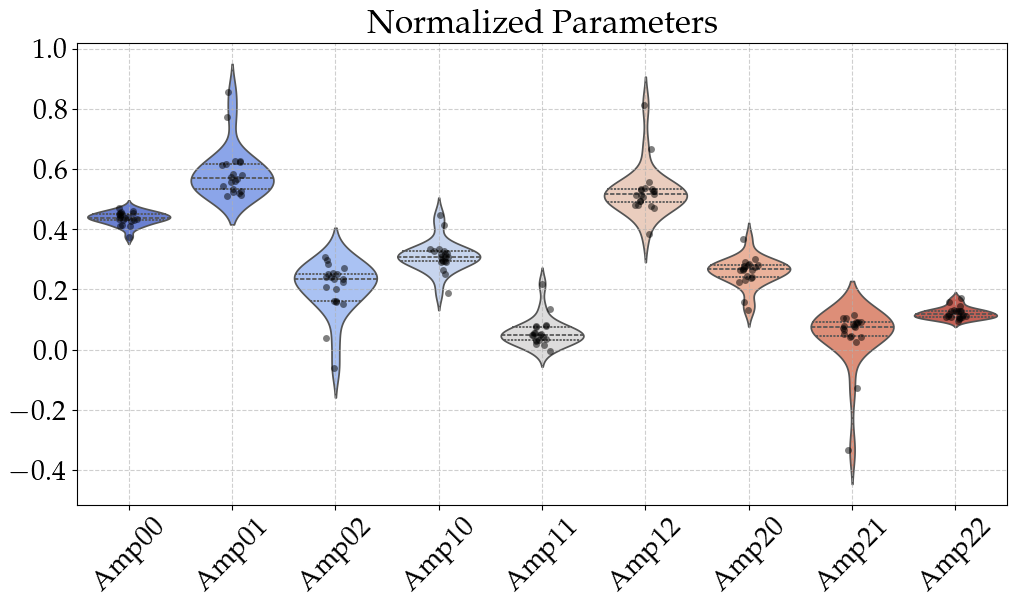

In [26]:
violin_plot(file_path, mode="AP_AP", selected_keys=gaussian_keys,params_true=params_true)

In [27]:
file_path = '../data/SpringMassModel/FullDomain/FitAllParams/Stats/FullDomain_len15_lr15_tol099_keepdataTrue_keepparamsTrue_etavarFalse.h5'
mode = 'AP_AP'
u_sol, u_sim, v_sol, v_sim, T_sol, T_sim, x_sol, x_sim, params = load_stat_data(file_path, mode)

Available runs: 14


Available runs: 14


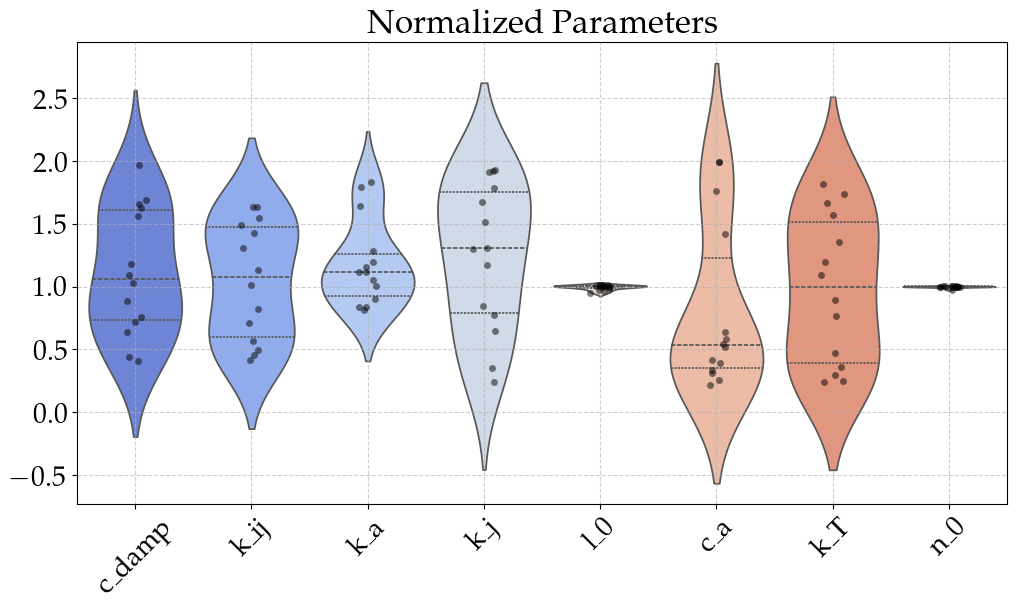

In [28]:
violin_plot(file_path, mode="AP_AP", selected_keys=mech_keys,params_true=params_true)

Available runs: 14


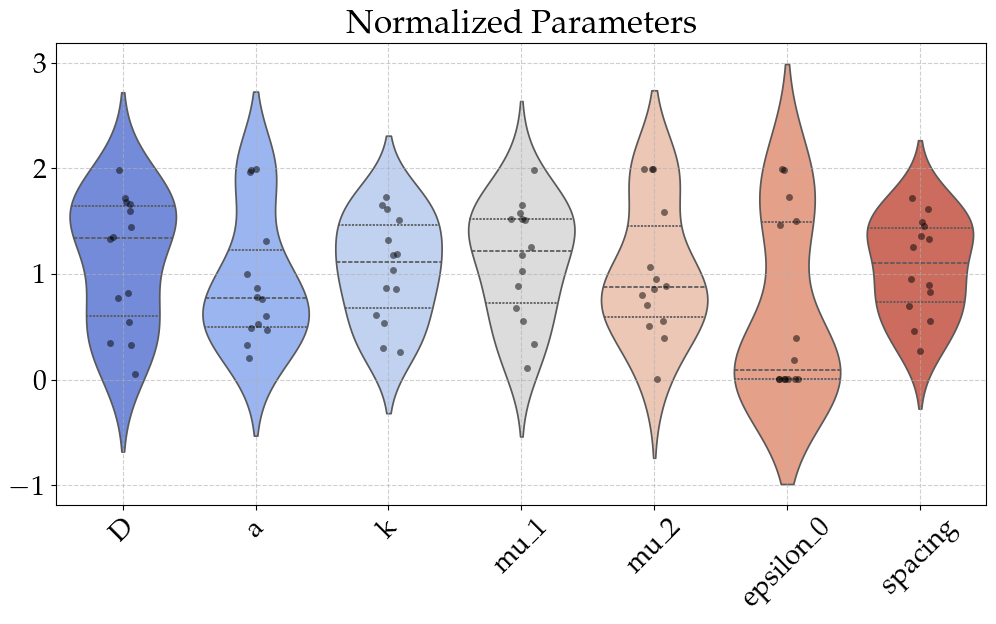

In [29]:
violin_plot(file_path, mode="AP_AP", selected_keys=electric_keys,params_true=params_true)